In [13]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\KAROLD\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
import sys
import os
import importlib

# Obtiene la ruta absoluta de la carpeta src
SRC_PATH = os.path.abspath(os.path.join(os.getcwd(), '../src'))
sys.path.insert(0, SRC_PATH)

# Forzar recarga del módulo
if 'preprocessing' in sys.modules:
    del sys.modules['preprocessing']

# Importar el módulo
try:
    from preprocessing import run_preprocessing
    print("¡Módulo importado correctamente!")
    
    # Ejecuta el procesamiento
    df = run_preprocessing(
        raw_folder='../data/raw/',
        processed_path='../data/processed/clean_reviews.csv'
    )

    print("\nDataset preprocesado cargado correctamente:")
    print(df.shape)
    print(df.head())

    print("\nArchivo guardado en:", os.path.exists('../data/processed/clean_reviews.csv'))
    
except ImportError as e:
    print(f"Error al importar: {e}")
    
    # Diagnosticar el problema
    import preprocessing
    print("\nFunciones disponibles en el módulo:")
    print([func for func in dir(preprocessing) if not func.startswith('_')])

¡Módulo importado correctamente!
Cargando datasets...
Dataset cargado: (2748, 2)
Limpieza y normalización del texto...
Dataset preprocesado guardado en: ../data/processed/clean_reviews.csv
Total de filas: 2727
Ejemplo de texto limpio:
                                        clean_sentence  label
1462  loved grilled pizza reminded legit italian pizza      1
1100                  everyone treated equally special      1
1781                 two year left contract hate phone      0

Dataset preprocesado cargado correctamente:
(2727, 2)
                                      clean_sentence  label
0        aimless movie distressed drifting young man      0
1  sure lost flat character audience nearly half ...      0
2  attempting artiness black white clever camera ...      0
3                        little music anything speak      0
4  best scene movie gerardo trying find song keep...      1

Archivo guardado en: True


In [6]:
# --- Exploratory data check ---
print("First 5 rows:")
print(df.head())

print("\nData set (filas, columnas):")
print(df.shape)

print("\nGeneral information:")
print(df.info())

print("\nDescriptive stats:")
print(df.describe(include='all'))

First 5 rows:
                                      clean_sentence  label
0        aimless movie distressed drifting young man      0
1  sure lost flat character audience nearly half ...      0
2  attempting artiness black white clever camera ...      0
3                        little music anything speak      0
4  best scene movie gerardo trying find song keep...      1

Data set (filas, columnas):
(2731, 2)

General information:
<class 'pandas.core.frame.DataFrame'>
Index: 2731 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   clean_sentence  2731 non-null   object
 1   label           2731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 64.0+ KB
None

Descriptive stats:
       clean_sentence        label
count            2731  2731.000000
unique           2671          NaN
top       great phone          NaN
freq                5          NaN
mean              NaN     0.503845
st

The movie review dataset contains **2,748 records** and **2 features**, representing individual movie review sentences and their corresponding sentiment labels. Each row corresponds to one review, and the target variable indicates whether the review is **positive (1)** or **negative (0)**.

| Column Type | Description                                                                                 |
| ----------- | ------------------------------------------------------------------------------------------- |
| sentence    | Text of the movie review. Each entry is a string of words, sometimes including punctuation. |
| label       | Target variable: 1 = positive sentiment, 0 = negative sentiment.                            |

Data types

* **Text:** `sentence` (object/string).
* **Categorical/Binary:** `label` (int: 0 or 1).

Initial observations

1. The dataset is **approximately balanced**, with 50.4% positive and 49.6% negative reviews.
3. The text data is **highly diverse**, with 2,731 unique sentences out of 2,748, indicating minimal repetition.
5. There are **no missing values** in either column, making it ready for preprocessing and modeling.

In [7]:
print(df.isnull().sum())
print(df.duplicated().sum())
print(df.nunique())
print(df['label'].value_counts())
print(df['label'].dtype)

clean_sentence    0
label             0
dtype: int64
52
clean_sentence    2671
label                2
dtype: int64
label
1    1376
0    1355
Name: count, dtype: int64
int64


With this analysis, we can say that:
1. There are no missing values
2. There are duplicated rows, so **we're going to delete them**
3. There are 2671 unique sentences and the 2 labels we know (positive and negative)
4. The distribution its almost 50/50, with 1386 positive sentences and 1362 negative sentences
5. The label's data type its an integer, which its accurate for a binary variable

In [8]:
df = df.drop_duplicates()

## Visual EDA

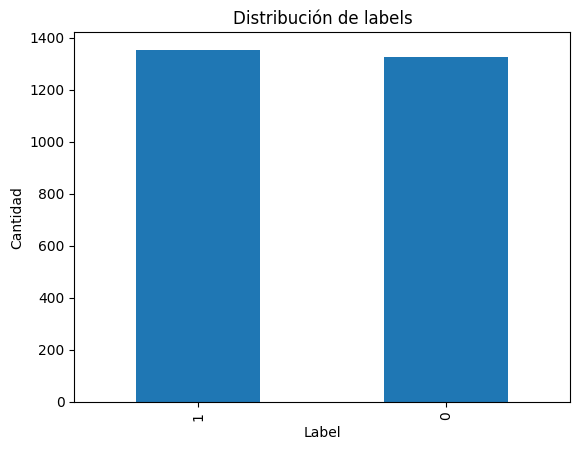

In [9]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar')
plt.title('Distribución de labels')
plt.xlabel('Label')
plt.ylabel('Cantidad')
plt.show()

As we said, the distribution its almost 50/50, which its perfect for model training.

In [10]:
df['num_words'] = df['clean_sentence'].apply(lambda x: len(x.split()))
df['num_chars'] = df['clean_sentence'].apply(len)

df[['num_words','num_chars']].describe()


,num_words,num_chars
count,2679.000000,2679.000000
mean,6.569989,43.280328
std,17.324718,121.226891
min,0.000000,0.000000
25%,3.000000,20.000000
50%,5.000000,33.000000
75%,8.000000,52.000000
max,665.000000,4732.000000


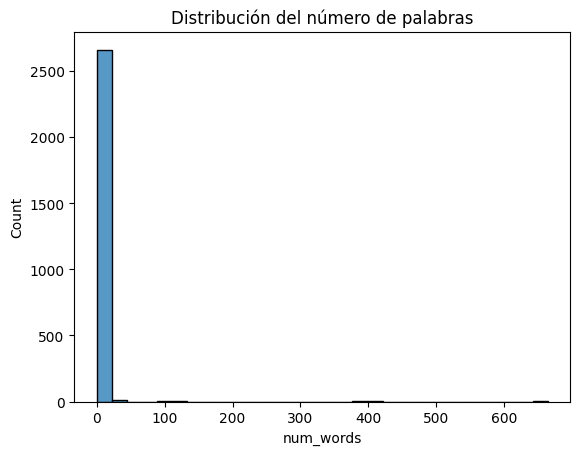

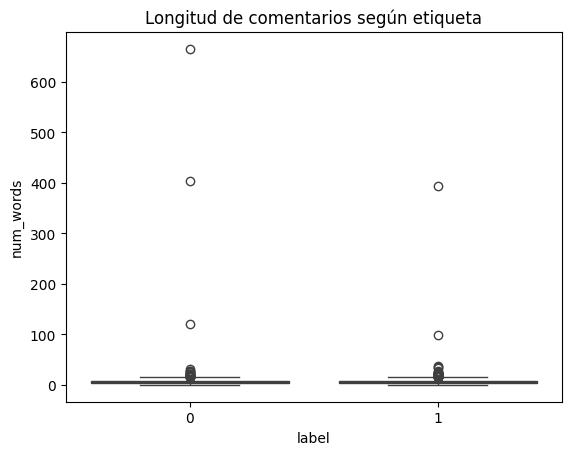

In [14]:
sns.histplot(df['num_words'], bins=30)
plt.title('Distribución del número de palabras')
plt.show()

sns.boxplot(x='label', y='num_words', data=df)
plt.title('Longitud de comentarios según etiqueta')
plt.show()

This tells us that most sententeces are pretty short, but there are some significantly larger ones (more than 100 words), than can create issues with our models. What we are going to do to fix this is to delete reviews with more than a 100 words.

In [15]:
df = df[df['num_words'] < 100]

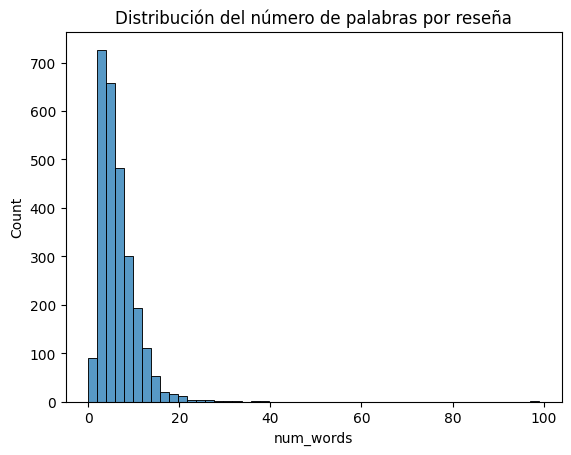

In [16]:
sns.histplot(df['num_words'], bins=50)
plt.title('Distribución del número de palabras por reseña')
plt.show()

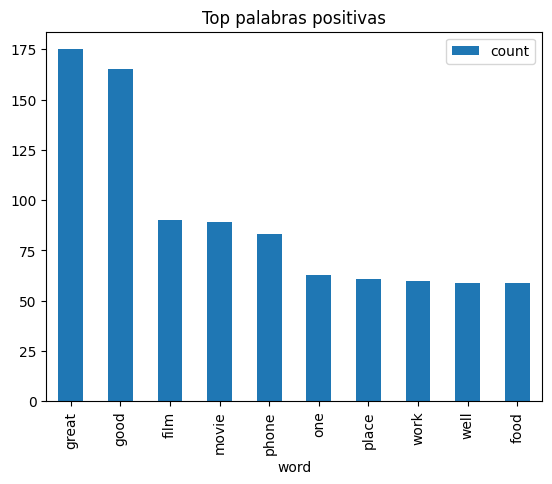

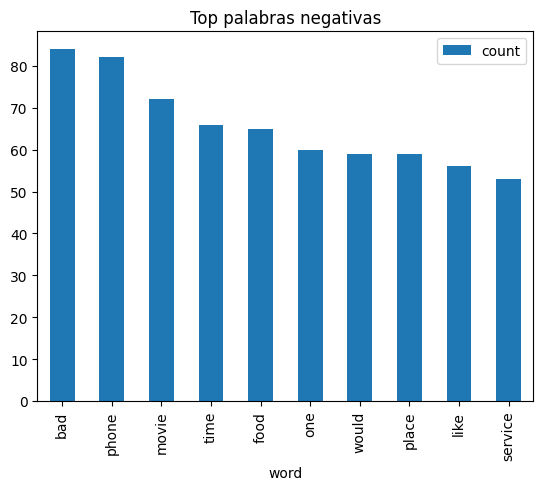

In [17]:
from collections import Counter
import pandas as pd

pos_counts = Counter(" ".join(df[df['label']==1]['clean_sentence']).lower().split())
neg_counts = Counter(" ".join(df[df['label']==0]['clean_sentence']).lower().split())

pd.DataFrame(pos_counts.most_common(10), columns=['word','count']).plot.bar(x='word',y='count',title='Top palabras positivas')
pd.DataFrame(neg_counts.most_common(10), columns=['word','count']).plot.bar(x='word',y='count',title='Top palabras negativas')
plt.show()